# Summarise the previous results: clean and add the volume and dual computation functions, validate the results

In [1]:


# ddg imports
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Imports and physical parameters
# std library

# plotting

# ddg imports
# Allow for relative imports from main library:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#from ddgclib._case1 import *
from ddgclib._capillary_rise import * #plot_surface#, curvature
from ddgclib._misc import *
from ddgclib._plotting import *

# Name the functions we are actually using:
#from barycentric._duals import compute_vd
# Example usage:

In [2]:
# compute duals (and Delaunay dual from a set of points)
from ddgclib.ddgclib.barycentric import compute_vd, triang_dual

# Plots
from ddgclib.ddgclib.barycentric import plot_dual_mesh_2D, plot_dual_mesh_3D

# Geometry and dual computations
from ddgclib.ddgclib.barycentric import area_of_polygon

# Area computations
from ddgclib.ddgclib.barycentric import d_area

# DDG gradient operations on primary edges (for continuum)
from ddgclib.ddgclib.barycentric import dP, dudt


In [3]:
points = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0], [0, 0, 1]])
area = area_of_polygon(points)

In [4]:
import numpy as np
L = 1  # m
Q = 1  # m3 / s
R = 1  # m
A = 1  # m2  # = 2 pi * R**2 # for pipe
# Domain:
x_lb = 0
x_ub = R
y_lb = 0
y_ub = R

P_in = 101325 # Pa (kg⋅m−1⋅s−2), atmospheric pressure
#u_in = 1  # m⋅s−2, initial and inlet velocity   
u_in = 0.001  # m⋅s−2, initial and inlet velocity

# Physical parameters
mu = 8.90 * 1e-4  # Pa·s
h = R  # m, plate seperation
Q = u_in * A  # m3/s, volumetric flowrate (CHECK)
G = (Q * 12 * mu) / (h**3)  # pressure gradient(?)
rho = 1000  # kg / m3
#G = dP/ L
Re = rho * Q * L / mu
# Pressure drop for pipe
dP_anal = (8 * np.pi * mu * L * Q) / (A**2)

## Initial conditions
# velocity
def v_IC(HC):
    # Assign velocity field to all points:
    for v in HC.V:
        v.u = np.array([u_ic(v.x_a), 0])
        
# velocity
def v_IC(HC, u_in):
    # Assign velocity field to all points:
    for v in HC.V:
        v.u = np.array([u_in, 0])

# mass 
def mass_IC(HC):
    # Set mass of each fluid particle:
    for v in HC.V:
        # Compute the dual area around a particle:
        area = d_area(v)
        V = area * 1  # m3, can be modified later
        # Set mass in kg
        v.m = rho * V
        
# Pressure IC (new)
def P_IC(HC):
    # Assign velocity field to all points:
    for v in HC.V:
        # NOTE: We assume that the vector here is in fact the 
        #       pressure _gradient_ potential, which is not 
        #       equivalent to the scalar pressure field.
        P_i = P_ic(v.x_a[0])
        v.P = np.array([P_i, P_i])  # Diagonal components # Pressure IC (new)
        
def P_IC(HC):
    # Assign velocity field to all points:
    for v in HC.V:
        # NOTE: We assume that the vector here is in fact the 
        #       pressure _gradient_ potential, which is not 
        #       equivalt to the scalar pressure field.
        P_i = P_ic(v.x_a[0])
        v.P = np.array([P_i, P_i])  # Diagonal components 
        
def P_ic(x):
    """
    Initial pressure condition (ASSUMED linear based on pressure drop)
    """
    return P_in - ((8 * np.pi * mu * x * Q) / (A**2))  # P_in - dP

# Initial condition:
def u_ic(x):
    y = x[1]
    return (G / 2 * mu) * y * (h - y)

# Solution
def u_plane_analytical(x):
    y = x[1]
    return (G / 2 * mu) * y * (h - y)

# Boundary conditions:
def u_bc(x):
    y = x[1]
    if y == 0:
        return 0.0
    elif y == h:
        return 0.0
    

def BC_bool(x):
    #if (x[0] == 0) or (x[0] == 1) or (x[1] == 0) or (x[1] == 1):
    #if (x[0]  == x_lb) or (x[0] == x_ub) or (x[1] == y_lb) or (x[1] == y_ub):
    if (x[1] == y_lb) or (x[1] == y_ub):
        return True
    else:
        return False
    
def in_domain(x):
    if (x[0] >= x_lb) and (x[0] <= x_ub) and (x[1] >= y_lb) and (x[1] <= y_ub):
        return True
    else:
        return False
    
# Test case 
def incomp_poiseuille_2d(refinements=2, R=1, u_in=0.1):
    # Solid boundaries of plate
    x_lb = 0
    x_ub = R  # For simplicity
    y_lb = 0
    y_ub = R  # Actual parallel plate dimension
    domain = [(x_lb, x_ub), (y_lb, y_ub)]
    points = incom_Poi(domain, refinements=refinements)
    HC, tri = triang_dual(points)
    #HC.vertex_face_mesh(field_conversions=True)              
    HC = compute_vd(HC)            
    # Optionally plot
    #plot_dual_mesh_2D(HC, tri)

    # For each vertex compute its local dual area:
    Areas = []
    for vp1 in HC.V:
        area = 0 
        area += d_area(vp1)
        Areas.append(area)

    # Set ICs:
    mass_IC(HC)  # mass IC
    v_IC(HC, u_in)  # Velocity IC
    P_IC(HC)  # Pressure field IC
    return HC, tri


In [5]:
# Test case traingulation
def incom_Poi(domain, refinements=2):
    """
    Compute the triangulate of a 2D incompressible Poiseuile flow
    """
    HC = Complex(2, domain)
    HC.triangulate()
    for i in range(refinements):
        HC.refine_all()

    points = []
    for v in HC.V:
        points.append(v.x_a)
    points = np.array(points, dtype='float64')
    tri = Delaunay(points)
    return points

# 2D

In [6]:
# Area computations
def d_volume(vp1, dim=2):
    """
    Compute the Barycentric dual volume (or area) 

    Parameters:
    -----------
    vp1 : object
        A vertex object containing the following attributes:
        - vp1.nn: a list of neighboring vertex objects
        - vp1.vd: a set of dual vertex objects
        - vp1.x_a: a numpy array representing the position of vp1

    Returns:
    --------
    darea : float
        The total dual area of the vertex object vp1
    """

    darea = 0  # Initialize total dual area to zero
    for vp2 in vp1.nn:  # Iterate over neighboring vertex objects
        # Find the shared dual vertices between vp1 and vp2
        vdnn = vp1.vd.intersection(vp2.vd)
        # Compute the midpoint between vp1 and vp2
        mp = (vp1.x_a + vp2.x_a) / 2
        # Compute the height of the dual triangle between vp1, vp2, and a dual vertex
        h = np.linalg.norm(mp - vp1.x_a)
        for vdi in vdnn:  # Iterate over shared dual vertices
            # Compute the base of the dual triangle between vp1, vp2, and vdi
            b = np.linalg.norm(vdi.x_a - mp)
            # Add the area of the dual triangle to the total dual area
            darea += 0.5 * b * h

    return darea

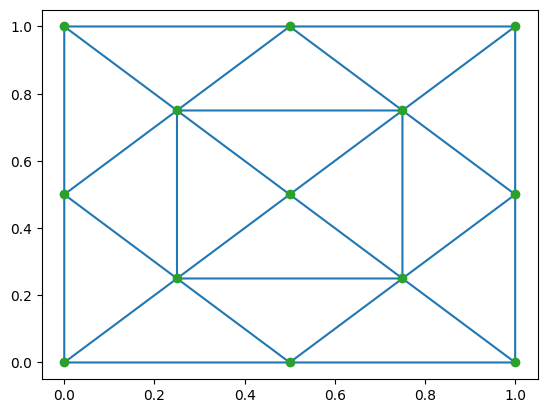

In [7]:
domain = [(0, 1),]*2
points = incom_Poi(domain, refinements=1)
HC, tri = triang_dual(points, plot_delaunay=True)
#HC.dim = 2
#HC = compute_vd(HC, cdist =1e-10)


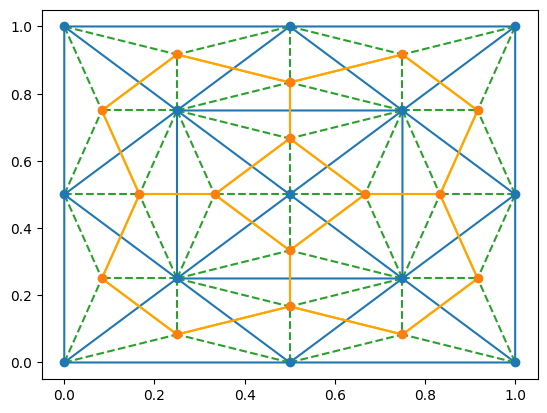

In [8]:
plot_dual_mesh_2D(HC, tri, points)

In [9]:
dual_points = []
for vd in HC.Vd:
    dual_points.append(vd.x_a)
dual_points = np.array(dual_points)

In [10]:
v_i =  HC.V[(0.5, 0.5)]
v_j =  HC.V[(0.75, 0.75)]

In [11]:
e_ij_star = 0  # Initialize total dual area to zero
# Find the shared dual vertices between vp1 and vp2
vdnn = v_i.vd.intersection(v_j.vd)  # Should always be 2 for dim=2

vd1 = list(vdnn)[0]
vd2 = list(vdnn)[1]
e_ij_star = np.linalg.norm(vd1.x_a - vd2.x_a) 
e_ij_star

0.23570226039551578912

# TODO: Compare the new integrators with the old using the case below:

In [12]:
# Pressure IC (new)
P_in = 101325 # Pa (kg⋅m−1⋅s−2), atmospheric pressure
mu = 8.90 * 1e-4  # Pa·s
A = 1  # m2
u_in = 0.0001  # m⋅s−2, initial and inlet velocity
u_in = 1e6# m⋅s−2, initial and inlet velocity
Q = u_in * A  # m3/s, volumetric flowrate (CHECK)

#Q = 1

def P_ic(x):
    """
    Initial pressure condition (ASSUMED linear based on pressure drop)
    """

    return P_in - ((8 * np.pi * mu * x * Q) / (A**2))  # P_in - dP

def P_IC(HC):
    # Assign velocity field to all points:
    for v in HC.V:
        # NOTE: We assume that the vector here is in fact the 
        #       pressure _gradient_ potential, which is not 
        #       equivalent to the scalar pressure field.
        P_i = P_ic(v.x_a[0])

        print(f'P_ic({v.x_a[0]}) = {P_ic(v.x_a[0])}')
        v.P = np.array([P_i, P_i])  # Diagonal components # Pressure IC (new)
        
P_IC(HC)
v_IC(HC, u_in)
mass_IC(HC)
v_i =  HC.V[(0.5, 0.5)]

P_ic(1.0) = 78956.86030644068
P_ic(0.75) = 84548.89522983051
P_ic(1.0) = 78956.86030644068
P_ic(0.5) = 90140.93015322034
P_ic(0.75) = 84548.89522983051
P_ic(1.0) = 78956.86030644068
P_ic(0.5) = 90140.93015322034
P_ic(0.25) = 95732.96507661017
P_ic(0.0) = 101325.0
P_ic(0.0) = 101325.0
P_ic(0.25) = 95732.96507661017
P_ic(0.0) = 101325.0
P_ic(0.5) = 90140.93015322034


In [13]:
dP(v_i, dim=2)

-
vp2.x, vp1.x = ((0.25, 0.25), (0.5, 0.5))
vp2.P - vp1.P = [5592.03492339 5592.03492339]
Area= 0.23570226039551587
-
vp2.x, vp1.x = ((0.25, 0.75), (0.5, 0.5))
vp2.P - vp1.P = [5592.03492339 5592.03492339]
Area= 0.23570226039551584
-
vp2.x, vp1.x = ((0.75, 0.25), (0.5, 0.5))
vp2.P - vp1.P = [-5592.03492339 -5592.03492339]
Area= 0.23570226039551584
-
vp2.x, vp1.x = ((0.75, 0.75), (0.5, 0.5))
vp2.P - vp1.P = [-5592.03492339 -5592.03492339]
Area= 0.23570226039551578
dP_i = [4.42201831e-13 4.42201831e-13]


array([4.42201831e-13, 4.42201831e-13], dtype=float128)

In [14]:
dudt(v_i, dim=2)

-
vp2.x, vp1.x = ((0.25, 0.25), (0.5, 0.5))
vp2.P - vp1.P = [5592.03492339 5592.03492339]
Area= 0.23570226039551587
-
vp2.x, vp1.x = ((0.25, 0.75), (0.5, 0.5))
vp2.P - vp1.P = [5592.03492339 5592.03492339]
Area= 0.23570226039551584
-
vp2.x, vp1.x = ((0.75, 0.25), (0.5, 0.5))
vp2.P - vp1.P = [-5592.03492339 -5592.03492339]
Area= 0.23570226039551584
-
vp2.x, vp1.x = ((0.75, 0.75), (0.5, 0.5))
vp2.P - vp1.P = [-5592.03492339 -5592.03492339]
Area= 0.23570226039551578
dP_i = [4.42201831e-13 4.42201831e-13]
du_i = [0. 0.]


array([-4.7462081e-15, -4.7462081e-15], dtype=float128)

In [15]:
v_i =  HC.V[(0.75, 0.75)]
dP(v_i, dim=2)

-
vp2.x, vp1.x = ((0.5, 0.5), (0.75, 0.75))
vp2.P - vp1.P = [5592.03492339 5592.03492339]
Area= 0.23570226039551578
-
vp2.x, vp1.x = ((0.75, 0.25), (0.75, 0.75))
vp2.P - vp1.P = [0. 0.]
Area= 0.16666666666666674
-
vp2.x, vp1.x = ((1.0, 1.0), (0.75, 0.75))
vp2.P - vp1.P = [-5592.03492339 -5592.03492339]
Area= 0.23570226039551578
-
vp2.x, vp1.x = ((0.25, 0.75), (0.75, 0.75))
vp2.P - vp1.P = [11184.06984678 11184.06984678]
Area= 0.16666666666666674
-
vp2.x, vp1.x = ((1.0, 0.5), (0.75, 0.75))
vp2.P - vp1.P = [-5592.03492339 -5592.03492339]
Area= 0.2635231383473649
-
vp2.x, vp1.x = ((0.5, 1.0), (0.75, 0.75))
vp2.P - vp1.P = [5592.03492339 5592.03492339]
Area= 0.2635231383473649
dP_i = [1864.01164113 1864.01164113]


array([1864.01164113, 1864.01164113], dtype=float128)

In [16]:
dudt(v_i, dim=2)

-
vp2.x, vp1.x = ((0.5, 0.5), (0.75, 0.75))
vp2.P - vp1.P = [5592.03492339 5592.03492339]
Area= 0.23570226039551578
-
vp2.x, vp1.x = ((0.75, 0.25), (0.75, 0.75))
vp2.P - vp1.P = [0. 0.]
Area= 0.16666666666666674
-
vp2.x, vp1.x = ((1.0, 1.0), (0.75, 0.75))
vp2.P - vp1.P = [-5592.03492339 -5592.03492339]
Area= 0.23570226039551578
-
vp2.x, vp1.x = ((0.25, 0.75), (0.75, 0.75))
vp2.P - vp1.P = [11184.06984678 11184.06984678]
Area= 0.16666666666666674
-
vp2.x, vp1.x = ((1.0, 0.5), (0.75, 0.75))
vp2.P - vp1.P = [-5592.03492339 -5592.03492339]
Area= 0.2635231383473649
-
vp2.x, vp1.x = ((0.5, 1.0), (0.75, 0.75))
vp2.P - vp1.P = [5592.03492339 5592.03492339]
Area= 0.2635231383473649
dP_i = [1864.01164113 1864.01164113]
du_i = [0. 0.]


array([-13.8242706, -13.8242706], dtype=float128)

# 3 D


In [17]:
domain = [(0, 2),]*3
#symmetry = [0, 1, 1]
HC = Complex(3, domain=domain, symmetry=None)
HC.triangulate()
compute_vd(HC, cdist =1e-10)
dual_points = []
for vd in HC.Vd:
    dual_points.append(vd.x_a)

dual_points = np.array(dual_points, dtype='float64')
#dual_points

[[0. 0. 0.]
 [2. 0. 2.]
 [1. 1. 1.]
 [0. 0. 2.]]
[[0. 0. 0.]
 [2. 0. 2.]
 [1. 1. 1.]
 [2. 0. 0.]]
[[0. 0. 0.]
 [2. 0. 2.]
 [0. 0. 2.]
 [1. 1. 1.]]
[[0. 0. 0.]
 [2. 0. 2.]
 [2. 0. 0.]
 [1. 1. 1.]]
[[0. 0. 0.]
 [0. 2. 0.]
 [0. 2. 2.]
 [1. 1. 1.]]
[[0. 0. 0.]
 [0. 2. 0.]
 [2. 2. 0.]
 [1. 1. 1.]]
[[0. 0. 0.]
 [0. 2. 0.]
 [1. 1. 1.]
 [0. 2. 2.]]
[[0. 0. 0.]
 [0. 2. 0.]
 [1. 1. 1.]
 [2. 2. 0.]]
[[0. 0. 0.]
 [0. 0. 2.]
 [2. 0. 2.]
 [1. 1. 1.]]
[[0. 0. 0.]
 [0. 0. 2.]
 [0. 2. 2.]
 [1. 1. 1.]]
[[0. 0. 0.]
 [0. 0. 2.]
 [1. 1. 1.]
 [2. 0. 2.]]
[[0. 0. 0.]
 [0. 0. 2.]
 [1. 1. 1.]
 [0. 2. 2.]]
[[0. 0. 0.]
 [2. 0. 0.]
 [2. 0. 2.]
 [1. 1. 1.]]
[[0. 0. 0.]
 [2. 0. 0.]
 [2. 2. 0.]
 [1. 1. 1.]]
[[0. 0. 0.]
 [2. 0. 0.]
 [1. 1. 1.]
 [2. 0. 2.]]
[[0. 0. 0.]
 [2. 0. 0.]
 [1. 1. 1.]
 [2. 2. 0.]]
[[0. 0. 0.]
 [0. 2. 2.]
 [0. 2. 0.]
 [1. 1. 1.]]
[[0. 0. 0.]
 [0. 2. 2.]
 [1. 1. 1.]
 [0. 2. 0.]]
[[0. 0. 0.]
 [0. 2. 2.]
 [1. 1. 1.]
 [0. 0. 2.]]
[[0. 0. 0.]
 [0. 2. 2.]
 [0. 0. 2.]
 [1. 1. 1.]]
[[0. 0. 0.]
 [2. 2. 

/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2906: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig_complex.show()


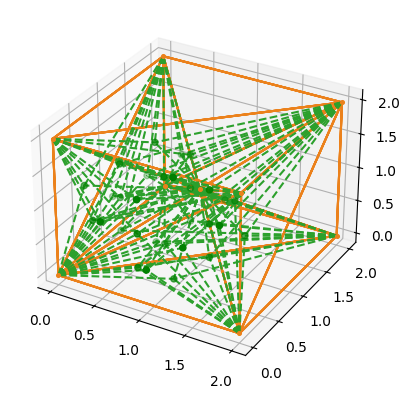

In [18]:
#hcaxes.scatter(dual_points)
plot_dual_mesh_3D(HC, dual_points)

In [19]:
for vd in HC.V:
    print(vd.x)

(0, 0, 0)
(2, 2, 2)
(2, 0, 0)
(0, 2, 0)
(2, 2, 0)
(0, 0, 2)
(2, 0, 2)
(0, 2, 2)
(1.0, 1.0, 1.0)


In [20]:
vi = HC.V[(1.0, 1.0, 1.0)]
vj = HC.V[(2, 2, 2)]

In [21]:
vdnn = vi.vd.intersection(vj.vd)
vdnn


{<barycentric._vertex.VertexScalarField at 0x762c0404cfd0>,
 <barycentric._vertex.VertexScalarField at 0x762c0404f010>}

In [22]:
import numpy as np

def area_of_polygon(points):
  """Calculates the area of a polygon in 3D space.

  Args:
    points: A numpy array of shape (n, 3), where each row represents a point in
      3D space.

  Returns:
    The area of the polygon.
  """

  # Calculate the cross product of each pair of adjacent edges.
  edges = points[1:] - points[:-1]
  cross_products = np.cross(edges[:-1], edges[1:])

  # Calculate the area of the triangle formed by each pair of adjacent edges and
  # the origin.
  triangle_areas = 0.5 * np.linalg.norm(cross_products, axis=1)

  # Sum the areas of all the triangles to get the total area of the polygon.
  return np.sum(triangle_areas)


# Example usage:

points = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0], [0, 0, 1]])
area = area_of_polygon(points)

print(area)

1.7071067811865475


In [23]:
local_dual_points = []
for vd in vdnn:
    local_dual_points.append(vd.x)
    
local_dual_points = np.array(local_dual_points)    
local_dual_points

array([[1.5 , 1.  , 0.5 ],
       [0.75, 0.75, 1.25],
       [0.75, 1.25, 1.25],
       [1.25, 0.75, 0.75],
       [1.25, 0.75, 0.25],
       [0.75, 0.25, 1.25],
       [0.75, 1.25, 0.25],
       [1.25, 0.25, 0.75],
       [0.75, 1.25, 0.75],
       [0.25, 0.75, 1.25],
       [1.25, 1.25, 0.75],
       [0.5 , 1.5 , 1.  ],
       [1.5 , 0.5 , 1.  ],
       [1.25, 0.75, 1.25],
       [0.5 , 1.  , 1.5 ],
       [1.  , 0.5 , 1.5 ],
       [1.  , 1.5 , 0.5 ],
       [0.25, 1.25, 0.75]])

In [24]:
area_of_polygon(local_dual_points)

4.615626654389818

In [25]:
e_ij_star = 0  # Initialize total dual area to zero
vdnn = vi.vd.intersection(vj.vd)
 
local_dual_points = []
for vd in vdnn:
    local_dual_points.append(vd.x)
    
local_dual_points = np.array(local_dual_points) 
e_ij_star = area_of_polygon(local_dual_points)
e_ij_star

4.615626654389818

# Extra test

In [26]:
domain = [(0, 0.5),]*3
#symmetry = [0, 1, 1]
HC = Complex(3, domain=domain, symmetry=None)
HC.triangulate()
compute_vd(HC, cdist =1e-10)
dual_points = []
for vd in HC.Vd:
    dual_points.append(vd.x_a)

dual_points = np.array(dual_points, dtype='float64')
#dual_points

[[0.   0.   0.  ]
 [0.5  0.   0.5 ]
 [0.   0.   0.5 ]
 [0.25 0.25 0.25]]
[[0.   0.   0.  ]
 [0.5  0.   0.5 ]
 [0.25 0.25 0.25]
 [0.   0.   0.5 ]]
[[0.   0.   0.  ]
 [0.5  0.   0.5 ]
 [0.25 0.25 0.25]
 [0.5  0.   0.  ]]
[[0.   0.   0.  ]
 [0.5  0.   0.5 ]
 [0.5  0.   0.  ]
 [0.25 0.25 0.25]]
[[0.   0.   0.  ]
 [0.   0.   0.5 ]
 [0.25 0.25 0.25]
 [0.   0.5  0.5 ]]
[[0.   0.   0.  ]
 [0.   0.   0.5 ]
 [0.25 0.25 0.25]
 [0.5  0.   0.5 ]]
[[0.   0.   0.  ]
 [0.   0.   0.5 ]
 [0.   0.5  0.5 ]
 [0.25 0.25 0.25]]
[[0.   0.   0.  ]
 [0.   0.   0.5 ]
 [0.5  0.   0.5 ]
 [0.25 0.25 0.25]]
[[0.   0.   0.  ]
 [0.5  0.5  0.  ]
 [0.25 0.25 0.25]
 [0.   0.5  0.  ]]
[[0.   0.   0.  ]
 [0.5  0.5  0.  ]
 [0.25 0.25 0.25]
 [0.5  0.   0.  ]]
[[0.   0.   0.  ]
 [0.5  0.5  0.  ]
 [0.   0.5  0.  ]
 [0.25 0.25 0.25]]
[[0.   0.   0.  ]
 [0.5  0.5  0.  ]
 [0.5  0.   0.  ]
 [0.25 0.25 0.25]]
[[0.   0.   0.  ]
 [0.   0.5  0.5 ]
 [0.   0.   0.5 ]
 [0.25 0.25 0.25]]
[[0.   0.   0.  ]
 [0.   0.5  0.5 ]
 [0.25 0.25 0.2

/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2906: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig_complex.show()


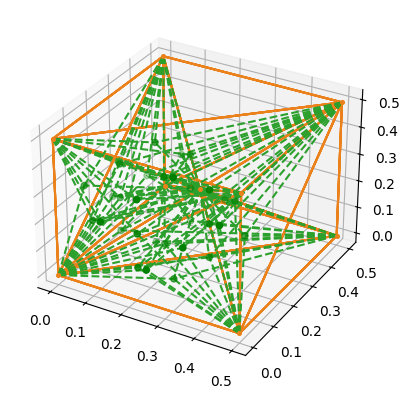

In [27]:
#hcaxes.scatter(dual_points)
   
plot_dual_mesh_3D(HC, dual_points)

In [28]:
def plot_dual_vertex_ps(v, HC, vector_field=None, scalar_field=None, fn='', up="x_up"
                   , stl=False):
    # Initialize polyscope
    ps.init()
    ps.set_up_dir('z_up')

    do = coldict['db']
    lo = coldict['lb']
    # Matplotlib tab:green color
    tg = (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
  
    # Create the dual mesh
    HC2 = Complex(3)
    v2 = HC2.V[v.x]
    for vd in v.vd:
        v2.connect(vd)
    
    # Loop over primary edges and connect (3 dual vertices)
    for vj in v.nn:
        dual_set = vj.vd.intersection(v.vd)
        print(len(vj.vd.intersection(v.vd)))  # Not working sadly, produces 4 and 6 (number of tetrahedron?)
        # Make a local triangulation:
        tri_2 = []
        if 1:
            from scipy.spatial import Delaunay
            points = []
            points_plane = []
            for p in dual_set:
                p1 = p.x[0] + 1e-7
                p2 = p.x[1] + 1e-7
                points_plane.append([p1, p2])
                points.append(p.x)
            
            points_plane = np.array(points_plane)
            points = np.array(points)
            tri = Delaunay(points_plane)
            HC2.vf_to_vv(points, tri.simplices)

    # plot the dual mesh
    if 1:
        HC2.dim = 2  # The dimension has changed to 2 (boundary surface)
        HC2.vertex_face_mesh()
        points = np.array(HC2.vertices_fm)
        triangles = np.array(HC2.simplices_fm_i)
        ### Register a point cloud
        # `my_points` is a Nx3 numpy array
        my_points = points
        ps_cloud = ps.register_point_cloud("my points", my_points)
        ps_cloud.set_color(tg)
        #ps_cloud.set_color((0.0, 0.0, 0.0))
        verts = my_points
        faces = triangles
    
        surface = ps.register_surface_mesh("Dual mesh", verts, faces,
                                 color=tg,
                                 edge_width=1.0,
                                 edge_color=(0.0, 0.0, 0.0),
                                 smooth_shade=False)
    
        surface.set_transparency(0.7)
            
    
    # Plot the original mesh
    if 0:
        HC.dim = 2  # The dimension has changed to 2 (boundary surface)
        HC.vertex_face_mesh()
        points = np.array(HC.vertices_fm)
        triangles = np.array(HC.simplices_fm_i)
        ### Register a point cloud
        # `my_points` is a Nx3 numpy array
        my_points = points
        ps_cloud = ps.register_point_cloud("my points", my_points)
        ps_cloud.set_color(tuple(do))
        #ps_cloud.set_color((0.0, 0.0, 0.0))
        verts = my_points
        faces = triangles
        if stl:
            print(f'verts = {verts}')
            print(f'faces = {faces}')
          #  msh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
            for i, f in enumerate(faces):
                for j in range(3):
                    pass
                    #msh.vectors[i][j] = verts[f[j], :]
    
            #msh.save(f'{fn}.stl')
        ### Register a mesh
        # `verts` is a Nx3 numpy array of vertex positions
        # `faces` is a Fx3 array of indices, or a nested list
        surface = ps.register_surface_mesh("my mesh", verts, faces,
                                 color=do,
                                 edge_width=1.0,
                                 edge_color=(0.0, 0.0, 0.0),
                                 smooth_shade=False)
    
        surface.set_transparency(0.3)
        # Add a scalar function and a vector function defined on the mesh
        # vertex_scalar is a length V numpy array of values
        # face_vectors is an Fx3 array of vectors per face
        if 0:
            ps.get_surface_mesh("my mesh").add_scalar_quantity("my_scalar",
                    vertex_scalar, defined_on='vertices', cmap='blues')
            ps.get_surface_mesh("my mesh").add_vector_quantity("my_vector",
                    face_vectors, defined_on='faces', color=(0.2, 0.5, 0.5))
    
        # View the point cloud and mesh we just registered in the 3D UI
        #ps.show()
    
        # Plot particles
        if 0:
            np_dist = 4.0
            radius = 3.0
    
            points = np.array([[0, 0, np_dist],
                               [0, 0, -np_dist]])
    
            cloud = ps.register_point_cloud("my points", points)
            cloud.set_enabled(False)  # disable
            cloud.set_enabled()  # default is true
            cloud.set_radius(radius, relative=False)  # radius in absolute world units
            cloud.set_color(tuple(do))  # rgb triple on [0,1]
            print(f'tuple(do) = tuple(do)')
    
            #print(help(ps.register_point_cloud))
            if 1:
                cloud2 = ps.register_point_cloud("my points 2", points)
                cloud2.set_enabled(False)  # disable
                cloud2.set_enabled()  # default is true
                cloud2.set_radius(radius + 0.35, relative=False)  # radius in absolute world units
                #cloud2.set_radius(radius + 0.4, relative=False)  # radius in absolute world units
    
                cloud2.set_color(tuple(lb))  # rgb triple on [0,1]
    
            print(f'tuple(do) = {tuple(do)}')
    
            def rgb2hex(r, g, b):
                return "#{:02x}{:02x}{:02x}".format(r, g, b)
            print(f'tuple(do) = {tuple(do)}')
            hex = rgb2hex(int(tuple(do)[0]*255),
                          int(tuple(do)[1]*255),
                          int(tuple(do)[2]*255))
            print(f'rgb2hex( = { hex}')

    # Ground plane options
    ps.set_ground_plane_mode("shadow_only")  # set +Z as up direction
    ps.set_ground_plane_height_factor(0.1)  # adjust the plane height
    ps.set_shadow_darkness(0.2)  # lighter shadows
    ps.set_shadow_blur_iters(2)  # lighter shadows
    ps.set_transparency_mode('pretty')
    #ps.look_at((0., -10., 0.), (0., 0., 0.))
    ps.look_at((1., -8., -8.), (0., 0., 0.))
    #ps.set_ground_plane_height_factor(x, is_relative=True)
    ps.set_screenshot_extension(".png")
    # Take a screenshot
    # It will be written to your current directory as screenshot_000000.jpg, etc
    ps.screenshot(fn)
    return ps




In [29]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

# Get the RGB values for 'tab:green'
tab_green_rgb = to_rgba(plt.get_cmap('tab10').colors[2])

# Print the RGB values
print(tab_green_rgb)

(0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1)


In [30]:
plot_dual_vertex_ps(vi, HC)
ps.show()

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 3.3.0 NVIDIA 550.54.14
12
18
12
18
12
12
12
12


In [31]:
vi2 = HC.V[(0.0, 0.0, 0.0)]
plot_dual_vertex_ps(vi2, HC)
ps.show()

7
7
7
7
18
7
7


In [32]:
vi = HC.V[(0.25, 0.25, 0.25)]

v = vi
HC2 = Complex(3)
v2 = HC2.V[v.x]

for vd in v.vd:
    v2.connect(vd)

# Loop over primary edges and connect (3 dual vertices)
for vj in v.nn:
    dual_set = vj.vd.intersection(v.vd)
    print(len(vj.vd.intersection(v.vd)))  # Not working sadly, produces 4 and 6 (number of tetrahedron?)
    # Make a local triangulation:
    if 1:
        from scipy.spatial import Delaunay
        points = []
        points_plane = []
        for p in dual_set:
            p1 = p.x[0] + 1e-7
            p2 = p.x[1] + 1e-7
            points_plane.append([p1, p2])
            points.append(p.x)
        
        points_plane = np.array(points_plane)
        points = np.array(points)
        tri = Delaunay(points_plane)
        HC2.vf_to_vv(points, tri.simplices)
    # vf_to_vv(self, vertices, simplices)
    if 0:
        for vd_i in dual_set:
            v2.connect(vd_i)  # not needed?
            for vd_j in dual_set:
                vd_i.connect(vd_j)
        
if 0:    
    for vdi in v.vd:
        vdi2 = HC2.V[vdi.x]
        v2.connect(vdi2)
        for vdj in v.vd:
            vdi2.connect(vdj)

12
18
12
12
12
18
12
12


In [33]:
from scipy.spatial import Delaunay
points = []
points_plane = []
for p in dual_set:
    p1 = p.x[0] + 1e-7
    p2 = p.x[1] + 1e-7
    points_plane.append([p1, p2])
    points.append(p.x)

points_plane = np.array(points_plane)
points = np.array(points)

tri = Delaunay(points_plane)

HC2.vf_to_vv(points, tri.simplices)

In [34]:
tri.simplices

array([[ 8,  9,  5],
       [ 2,  1,  6],
       [ 1,  2,  0],
       [ 2,  5,  0],
       [ 2,  8,  5],
       [ 8, 11,  9],
       [ 9, 11,  7],
       [11,  2,  6],
       [ 2, 11,  8]], dtype=int32)

In [35]:
for vj in vi.nn:
    e_ij_star = 0  # Initialize total dual area to zero
    vdnn = vi.vd.intersection(vj.vd)
    print(len(list(vdnn)))
    local_dual_points = []
    for vd in vdnn:
        local_dual_points.append(vd.x)

    local_dual_points = np.array(local_dual_points) 
    e_ij_star = area_of_polygon(local_dual_points)
    print(e_ij_star)

12
0.09128343333475841
18
0.17007720291791456
12
0.07015918782166564
12
0.10027058449808927
12
0.09599909798927823
18
0.24531926519641511
12
0.1039356185548739
12
0.09912095954968554


In [36]:
# Bard AI code 

import numpy as np

def volume_of_geometric_object(points, extra_point):
  """Calculates the volume of a geometric object defined by adding an extra
  point away from the plane and connecting all points in the plane to it.

  Args:
    points: A numpy array of shape (n, 3), where each row represents a point in
      3D space.
    extra_point: A numpy array of shape (3,), representing the extra point away
      from the plane.

  Returns:
    The volume of the geometric object.
  """

  # Calculate the area of the base polygon.
  base_area = area_of_polygon(points)

  # Calculate the distance between the extra point and the base polygon.
  distance = np.linalg.norm(extra_point - np.mean(points, axis=0))

  # Calculate the volume of the geometric object.
  volume = base_area * distance

  return volume


# Example usage:

points = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0]])
extra_point = np.array([0, 0, 1])
volume = volume_of_geometric_object(points, extra_point)

print(volume)


1.224744871391589


# Test pyramid

In [37]:

# Create a pyramid with a known volume of pyramid_volume = 166.67
pyramid_points = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
                          [0.5, 0.5, 1]])

pyramid_points[:-1], pyramid_points[-1]

(array([[0., 0., 0.],
        [1., 0., 0.],
        [1., 1., 0.],
        [0., 1., 0.]]),
 array([0.5, 0.5, 1. ]))

In [38]:
# Create a pyramid with a known volume of pyramid_volume = 166.67
pyramid_points = np.array([[0, 0, 0], [10, 0, 0], [10, 10, 0], [0, 10, 0],
                          [5, 5, 5]])

volume_of_geometric_object(pyramid_points[:-1], pyramid_points[-1])

500.0

In [39]:

import numpy as np

def volume_of_geometric_object(points, extra_point):
  """Calculates the volume of a geometric object defined by adding an extra
  point away from the plane and connecting all points in the plane to it.

  Args:
    points: A numpy array of shape (n, 3), where each row represents a point in
      3D space.
    extra_point: A numpy array of shape (3,), representing the extra point away
      from the plane.

  Returns:
    The volume of the geometric object.
  """

  # Calculate the normal vector to the plane that contains the base polygon.
  normal_vector = np.cross(points[1] - points[0], points[2] - points[0])

  # Calculate the projection of the extra point onto the plane.
  projected_extra_point = extra_point - np.dot(extra_point - points[0], normal_vector) / np.linalg.norm(normal_vector)**2 * normal_vector

  # Calculate the distance between the extra point and its projection onto the plane.
  distance = np.linalg.norm(extra_point - projected_extra_point)

  # Calculate the area of the base polygon.
  base_area = area_of_polygon(points)

  # Calculate the volume of the geometric object.
  volume = 1/3 * base_area * distance

  return volume


In [40]:
# Create a pyramid with a known volume of pyramid_volume = 166.67
pyramid_points = np.array([[0, 0, 0], [10, 0, 0], [10, 10, 0], [0, 10, 0],
                          [5, 5, 5]])

volume_of_geometric_object(pyramid_points[:-1], pyramid_points[-1])

166.66666666666663

In [41]:
import numpy as np
#from volume_of_geometric_object import volume_of_geometric_object

# Create a pyramid with a known volume.
pyramid_points = np.array([[0, 0, 0], [10, 0, 0], [10, 10, 0], [0, 10, 0],
                          [5, 5, 5]])
pyramid_volume = 166.67

# Calculate the volume of the pyramid using your code.
pyramid_volume_calculated = volume_of_geometric_object(pyramid_points[:-1], pyramid_points[-1])

# Compare the calculated volume to the known volume.
pyramid_volume_calculated

166.66666666666663

# Area tests 

In [42]:
edges 

NameError: name 'edges' is not defined

In [ ]:
# Calculate the cross product of each pair of adjacent edges.
points = square_points
edges = points[1:] - points[:-1]
cross_products = np.cross(edges[:-1], edges[1:])

# Calculate the area of the triangle formed by each pair of adjacent edges and
# the origin.
triangle_areas = 0.5 * np.linalg.norm(cross_products, axis=1)

# Sum the areas of all the triangles to get the total area of the polygon.
return np.sum(triangle_areas)

In [ ]:
"""Tests the area of a square."""

square_points = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0]])
expected_area = 1

calculated_area = area_of_polygon(square_points)
calculated_area 

In [ ]:
"""Tests the area of a square."""

square_points = np.array([[0, 0, 0], [2, 0, 0], [2, 2, 0], [0, 2, 0]])
expected_area = 1

calculated_area = area_of_polygon(square_points)
calculated_area 

In [ ]:
"""Tests the area of a triangle."""

triangle_points = np.array([[0, 0, 0], [1, 0, 0], [0.5, 1, 0]])
expected_area = 0.5

calculated_area = area_of_polygon(triangle_points)
calculated_area

In [ ]:
"""Tests the area of a polygon with holes."""

polygon_points = np.array([[0, 0, 0], [1, 0], [1, 1], [0, 1], [0.5, 0.5]])
hole_points = np.array([[0.25, 0.25], [0.75, 0.25], [0.75, 0.75], [0.25, 0.75]])
expected_area = 1 - 0.25

calculated_area = area_of_polygon(polygon_points, [hole_points])

In [ ]:
import numpy as np
#from area_of_polygon import area_of_polygon

def test_area_of_square():
  """Tests the area of a square."""

  square_points = np.array([[0, 0], [1, 0], [1, 1], [0, 1]])
  expected_area = 1

  calculated_area = area_of_polygon(square_points)

  assert calculated_area == expected_area

def test_area_of_triangle():
  """Tests the area of a triangle."""

  triangle_points = np.array([[0, 0], [1, 0], [0.5, 1]])
  expected_area = 0.5

  calculated_area = area_of_polygon(triangle_points)

  assert calculated_area == expected_area

def test_area_of_polygon_with_holes():
  """Tests the area of a polygon with holes."""

  polygon_points = np.array([[0, 0], [1, 0], [1, 1], [0, 1], [0.5, 0.5]])
  hole_points = np.array([[0.25, 0.25], [0.75, 0.25], [0.75, 0.75], [0.25, 0.75]])
  expected_area = 1 - 0.25

  calculated_area = area_of_polygon(polygon_points, [hole_points])

  assert calculated_area == expected_area

Finally we develop the 3D version of e_ij_star.

In [ ]:
domain = [(0, 2),]*3
#symmetry = [0, 1, 1]
HC = Complex(3, domain=domain, symmetry=None)
HC.triangulate()
compute_vd(HC, cdist =1e-10)
dual_points = []
for vd in HC.Vd:
    dual_points.append(vd.x_a)

dual_points = np.array(dual_points, dtype='float64')
#dual_points
vi = HC.V[(0.25, 0.25, 0.25)]